# Image detection

In [13]:
import ultralytics

In [14]:
ultralytics.checks()

Ultralytics YOLOv8.0.51 🚀 Python-3.10.6 torch-1.13.1+cu117 CUDA:0 (NVIDIA GeForce GTX 1080, 8111MiB)
Setup complete ✅ (8 CPUs, 31.3 GB RAM, 36.7/217.5 GB disk)


## Inference

In [15]:
model = ultralytics.YOLO('models/yolov8s-agar-s480-b10-e50.pt')

In [16]:
results = model.predict('data/creighton')


image 1/7 /mnt/d/projects/colony/data/creighton/IM10CN-R2A_edit.jpeg: 480x480 3 unknowns, 14 b_subtiliss, 30 s_aureuss, 5 e_colis, 8.8ms
image 2/7 /mnt/d/projects/colony/data/creighton/IM10CN-TSA_edit.jpeg: 480x480 3 unknowns, 6 b_subtiliss, 24 s_aureuss, 52 e_colis, 7.3ms
image 3/7 /mnt/d/projects/colony/data/creighton/IM50-TSA_edit.jpeg: 480x480 1 unknown, 2 b_subtiliss, 70 s_aureuss, 79 e_colis, 29 p_aeruginosas, 7.4ms
image 4/7 /mnt/d/projects/colony/data/creighton/TH10N-R2A_edit.jpeg: 480x480 1 unknown, 10 b_subtiliss, 25 s_aureuss, 19 e_colis, 7.1ms
image 5/7 /mnt/d/projects/colony/data/creighton/TH10N-TSA_edit.jpeg: 480x480 13 s_aureuss, 287 e_colis, 7.4ms
image 6/7 /mnt/d/projects/colony/data/creighton/TH50CN-R2A_edit.jpeg: 480x480 9 b_subtiliss, 30 s_aureuss, 18 e_colis, 7.3ms
image 7/7 /mnt/d/projects/colony/data/creighton/TH50CN-TSA_edit.jpeg: 480x480 2 unknowns, 17 s_aureuss, 47 e_colis, 7.1ms
Speed: 0.3ms preprocess, 7.5ms inference, 4.1ms postprocess per image at shape (

In [62]:
# Record prediction results to disk.
import json
import pathlib

def box_to_dict(box, class_map):
    min_x, min_y, max_x, max_y = box.xyxy.numpy()[0]
    return {
        'class': class_map.get(box.cls.numpy()[0]) or '',
        'min_x': int(min_x),
        'min_y': int(min_y),
        'max_x': int(max_x),
        'max_y': int(max_y),
        }

def result_to_dict(result):
    height, width = result.orig_shape
    path = pathlib.Path(result.path)
    class_map = result.names
    return {'image':{'width':width, 'height':height, 'name':path.name},
            'boxes':[box_to_dict(b.cpu(), class_map) for b in result.boxes]}

for result in results:
    path = pathlib.Path(result.path)
    json_path = path.parent / f"{path.name.split('.')[0]}-predicted.json"
    json_string = json.dumps(result_to_dict(result), indent=2)
    with open(json_path, 'w') as f:
        f.write(json_string)

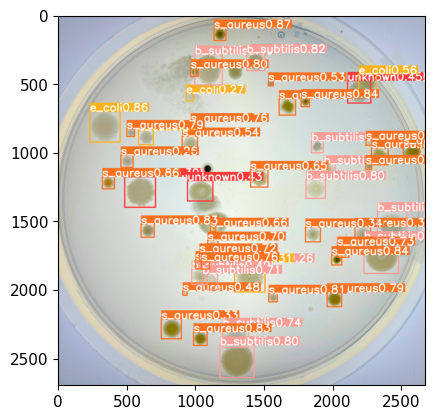

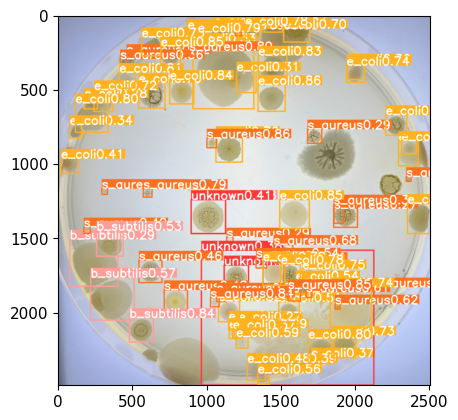

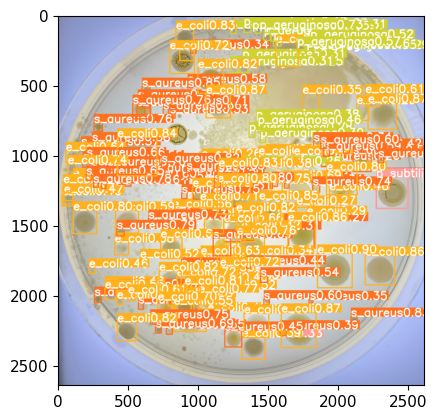

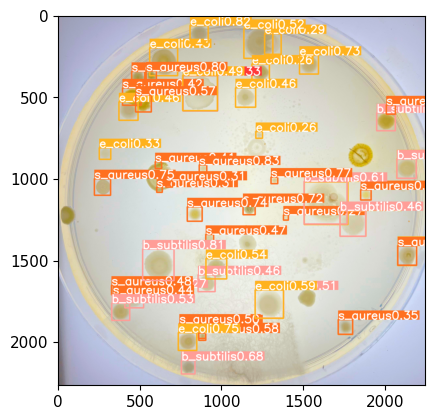

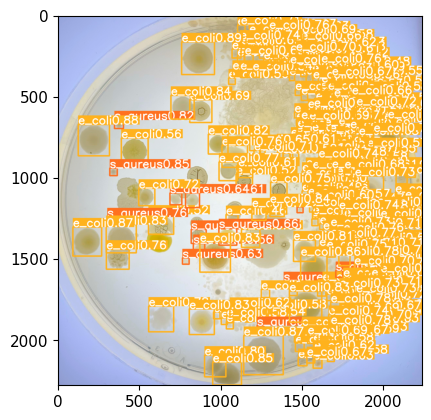

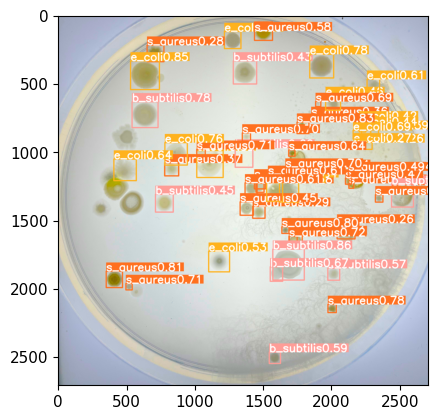

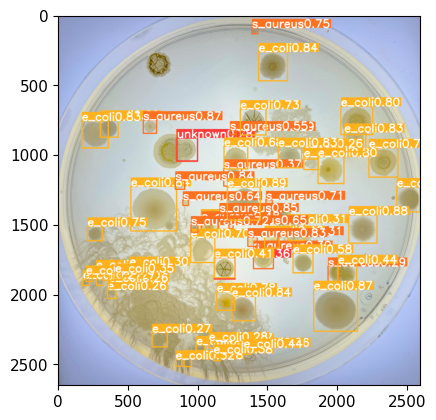

In [10]:
%matplotlib inline
import cv2
from matplotlib import pyplot as plt

for result in results:
    img = cv2.cvtColor(result.plot(), cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()

In [ ]:
result.numpy

## Data processing

In [ ]:
%matplotlib inline

import json
import os
import pathlib

import numpy as np

from PIL import Image
from matplotlib import pyplot as plt
from matplotlib import patches

# Setup the location for the AGAR dataset.
DATA_PATH = 'data/agar/dataset/'


In [ ]:
# Determine unique labels from dataset.
label_set = set([])

for c, file_path in enumerate(pathlib.Path(DATA_PATH).glob('*.json')):
    if c % 1000 == 0:
        print(f'Files opened: {c}')
    with open(file_path, 'r') as f:
        json_dict = json.loads(f.read())
        label_set.update(json_dict['classes'])

with open(os.path.join(DATA_PATH, '../labels.txt')) as f:
    for c, label in enumerate(label_set):
        f.write(f'{c+1}:{label}\n')

In [ ]:
# Read the class labels back from disk.

class_labels = {}
with open(os.path.join(DATA_PATH, '../labels.txt')) as f:
    class_string = f.read()
    for class_tuple in class_string.split('\n'):
        if class_tuple:
            class_id, class_name = class_tuple.split(':')
            class_labels[class_name] =  int(class_id)

In [ ]:
# Convert the JSON labels into TXT equivalent files.

# Expected format for the label files is image000.txt with rows of:
# class_number box1_x1_ratio box1_y1_ratio box1_width_ratio box1_height_ratio
# The json records (x,y) as the ll_corner and txt encodes it as center.
def convert_json_to_txt_label(label_dict, image_width, image_height, class_dict, default_class_id=0):
    class_id = class_dict.get(label_dict['class']) or default_class_id
    return [class_id, 
            (label_dict['x'] + 0.5 * label_dict['width']) / image_width,
            (label_dict['y'] + 0.5 * label_dict['height']) / image_height,
            label_dict['width'] / image_width,
            label_dict['height'] / image_height,
            ]

for c in range(1,18000+1):
    if c % 1000 == 0:
        print(f'Processed {c}')
    try:
        im = Image.open(os.path.join(DATA_PATH, f'{c}.jpg'))
        with open(os.path.join(DATA_PATH, f'{c}.json'), 'r') as f:
            json_dict = json.loads(f.read())
        with open(os.path.join(DATA_PATH, f'{c}.txt'), 'w') as f:
            if 'labels' in json_dict:
                for class_bbox in json_dict['labels']:
                    id, x, y, w, h = convert_json_to_txt_label(class_bbox, im.width, im.height, class_labels)
                    f.write(f'{id:d} {x} {y} {w} {h}\n')
    except Exception as err:
        print(f'Image {c} failed.\nERROR= {err=}\nTYPE= {type(err)=}')

In [ ]:
index = 4001
im = Image.open(os.path.join(DATA_PATH, f'{index}.jpg'))
with open(os.path.join(DATA_PATH, f'{index}.json'), 'r') as f:
    json_dict = json.loads(f.read())
with open(os.path.join(DATA_PATH, f'{index}.txt'), 'r') as f:
    bbox_raw = [[float(x) for x in line.split(' ') if x] for line in f.read().split('\n') if line]



In [ ]:
# Create figure and axes for the original JSON data.
fig, ax = plt.subplots()
ax.imshow(im)
ax.grid(visible=False)
for bbox in json_dict['labels']:
    # Create a Rectangle patch
    rect = patches.Rectangle((bbox['x'], bbox['y']), bbox['width'], bbox['height'], linewidth=1, edgecolor='r', facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
plt.show()

# Create figure and axes for the new TXT data.
fig, ax = plt.subplots()
ax.imshow(im)
ax.grid(visible=False)
for bbox in bbox_raw:
    x = im.width * bbox[1]
    y = im.height * bbox[2]
    w = im.width * bbox[3]
    h = im.height * bbox[4]
    rect = patches.Rectangle((x-0.5*w, y-0.5*h), w, h, linewidth=1, edgecolor='b', facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
plt.show()

## Training

In [3]:
model = ultralytics.YOLO('models/yolov8s-blood-cell-detection.pt')

In [ ]:
# yolo train model="models/yolov8s-blood-cell-detection.pt" data="data/agar/agar.yaml" epochs=50 imgsz=480 batch=8
model.train(data='data/agar/agar.yaml', imgsz=480, batch=8, epochs=3)

# Image classification

In [10]:
%matplotlib inline
import json
import pathlib

import numpy as np

from matplotlib import pyplot as plt
from PIL import Image
from transformers import AutoProcessor, CLIPVisionModel

In [2]:
model = CLIPVisionModel.from_pretrained("./models/clip-vit-base-patch32-vision-model")
processor = AutoProcessor.from_pretrained("./models/clip-vit-base-patch32-vision-model")

In [5]:
def image_patches_from_json(path_to_json, pad_for_scale=True):
    json_path = pathlib.Path(path_to_json)
    with open(json_path, 'r') as f:
        json_dict = json.loads(f.read())
    image_path = json_path.parent / json_dict['image']['name']
    pad_size = int(json_dict['image']['width'] / 10)
    img_array = np.array(Image.open(image_path))
    img_patches = []
    for box in json_dict['boxes']:
        patch_array = img_array[box['min_y']:box['max_y'], box['min_x']:box['max_x'], :]
        rows, cols, _ = patch_array.shape
        if pad_for_scale and rows < pad_size and cols < pad_size:
            patch_array = np.pad(patch_array, pad_width=((0, pad_size - rows), (0, pad_size - cols), (0, 0)), mode='constant', constant_values=0)
        img_patches.append(Image.fromarray(patch_array))
    return img_patches

In [52]:
images_patches = []
pooled_outputs = []
for pth in pathlib.Path('data/creighton/').glob('*.json'):
    imgs = image_patches_from_json(pth, pad_for_scale=True)
    print(f'Processing {len(imgs)} images from {pth.name}')
    inputs = processor(images=imgs, return_tensors="pt")
    outputs = model(**inputs)
    images_patches.append(imgs)
    pooled_outputs.append(outputs.pooler_output.detach().numpy())

Processing 52 images from IM10CN-R2A_edit-predicted.json
Processing 85 images from IM10CN-TSA_edit-predicted.json
Processing 181 images from IM50-TSA_edit-predicted.json
Processing 55 images from TH10N-R2A_edit-predicted.json
Processing 300 images from TH10N-TSA_edit-predicted.json
Processing 57 images from TH50CN-R2A_edit-predicted.json
Processing 66 images from TH50CN-TSA_edit-predicted.json


max=1.0 min=0.5108366012573242


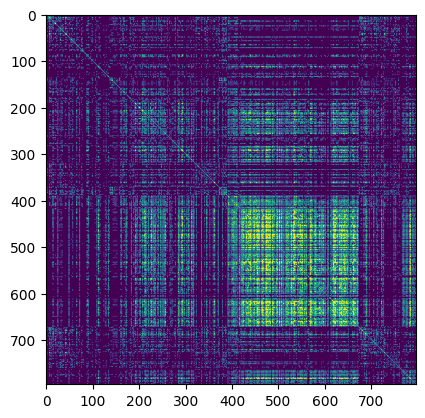

In [55]:
idx = -1
if idx < 0:
    pooled_output = np.concatenate(pooled_outputs)
    image_patches = [m for imgs in images_patches for m in imgs]
else:
    pooled_output = pooled_outputs[idx]
    image_patches = images_patches[idx]

correlated_output = np.sqrt(pooled_output @ pooled_output.T)
correlated_output /= np.max(correlated_output[:])
print(f'max={np.max(correlated_output[:])} min={np.min(correlated_output[:])}')
plt.imshow(correlated_output > 0.92)
plt.show()

max=32.87018585205078 min=0.0


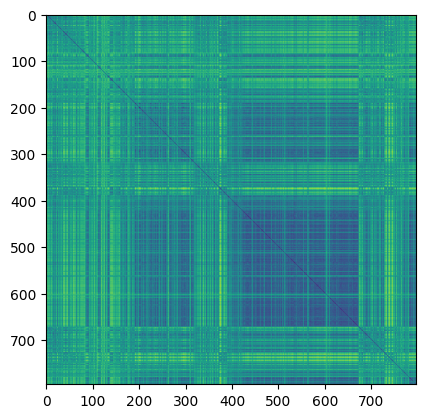

In [36]:
distance_map = [[np.linalg.norm(r - c) for c in pooled_output] for r in pooled_output]
print(f'max={np.max(distance_map[:])} min={np.min(distance_map[:])}')
plt.imshow(distance_map)
plt.show()

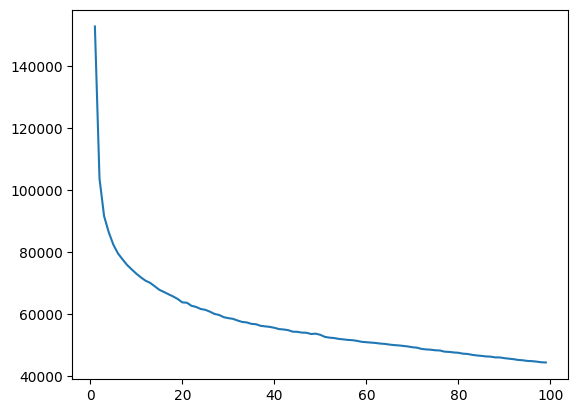

In [44]:
from sklearn import cluster


kmeans_kwargs = {
    'init': 'random',
    'n_init': 10,
    'max_iter': 300,
    'random_state': 42
}

sse = []
k_range = list(range(1,int(np.min([100,0.5*len(pooled_output)]))))
for k in k_range:
    kmeans = cluster.KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(pooled_output)
    sse.append(kmeans.inertia_)
plt.plot(k_range, sse)
plt.show()

In [56]:
n_clusters = 15
kmeans = cluster.KMeans(n_clusters=n_clusters, **kmeans_kwargs)
kmeans.fit(pooled_output)
image_clusters = {c:[] for c in range(n_clusters)}
for c, label in enumerate(kmeans.labels_):
    image_clusters[label].append(image_patches[c])


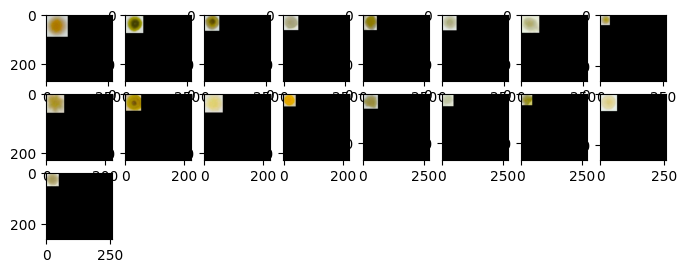

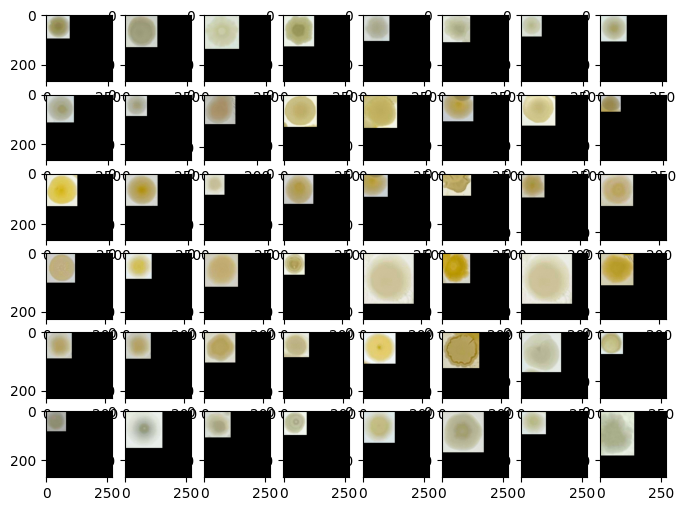

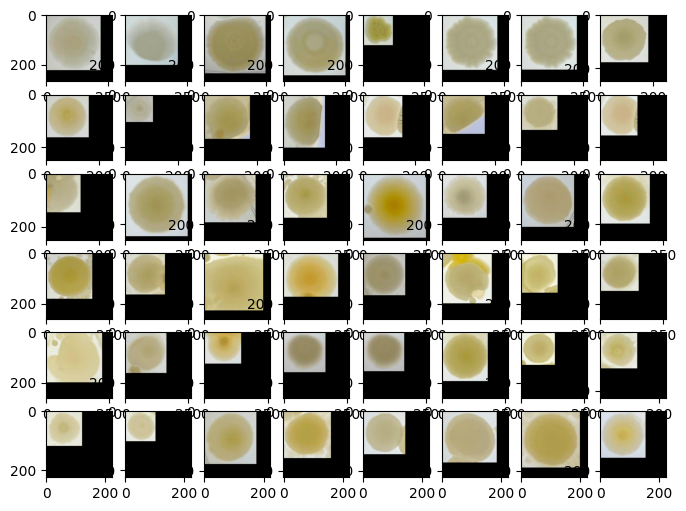

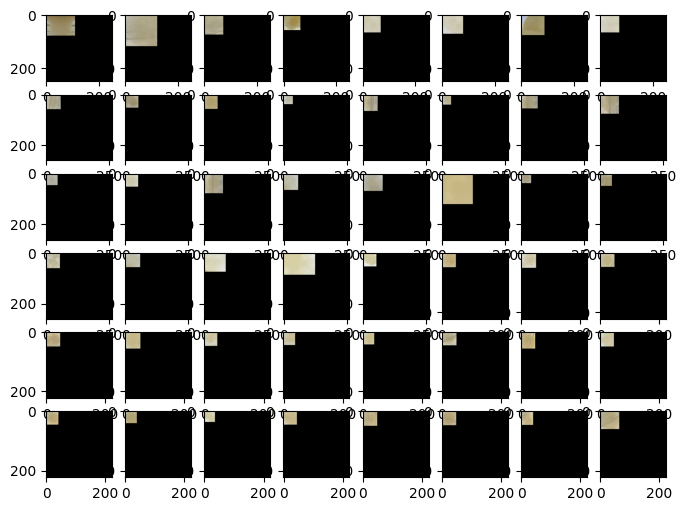

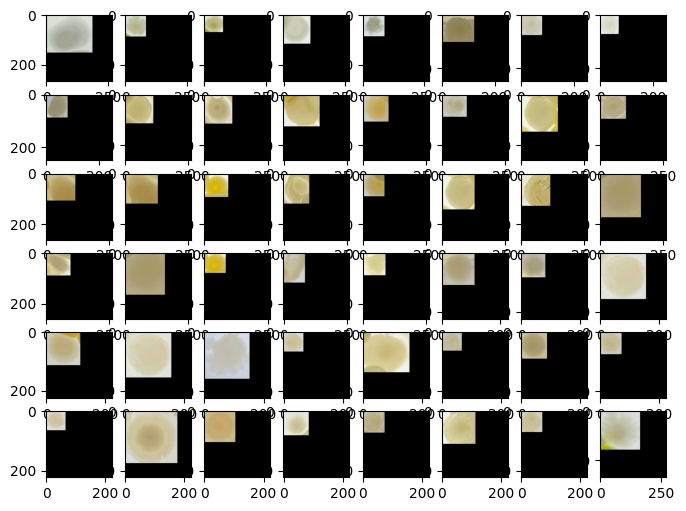

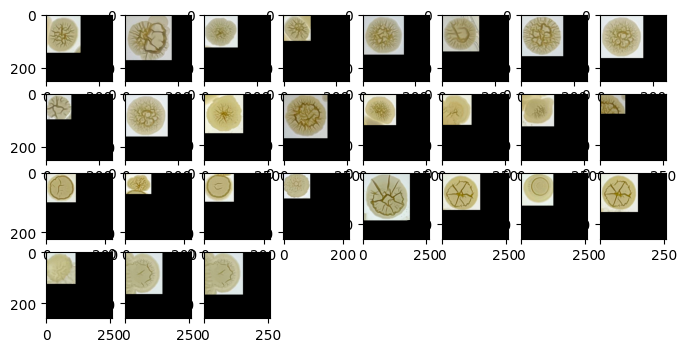

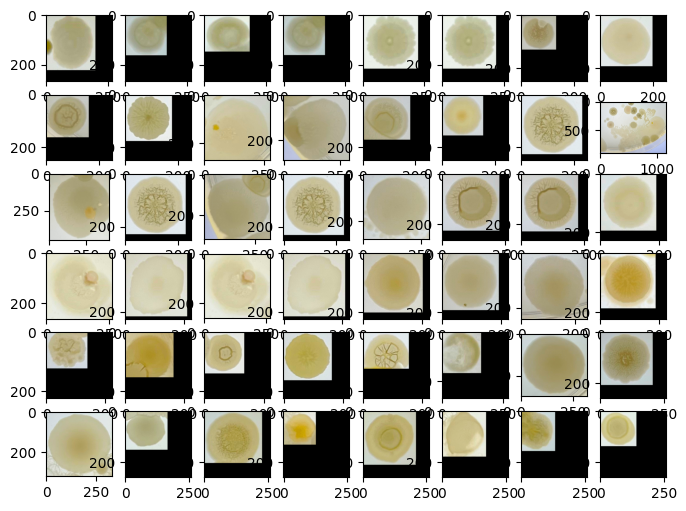

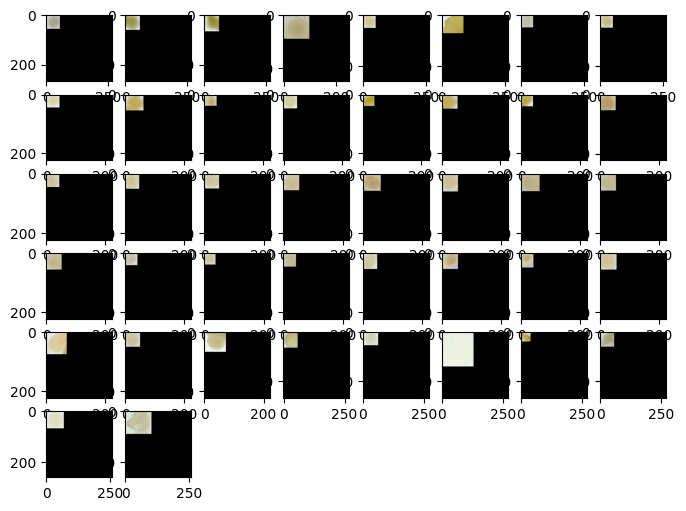

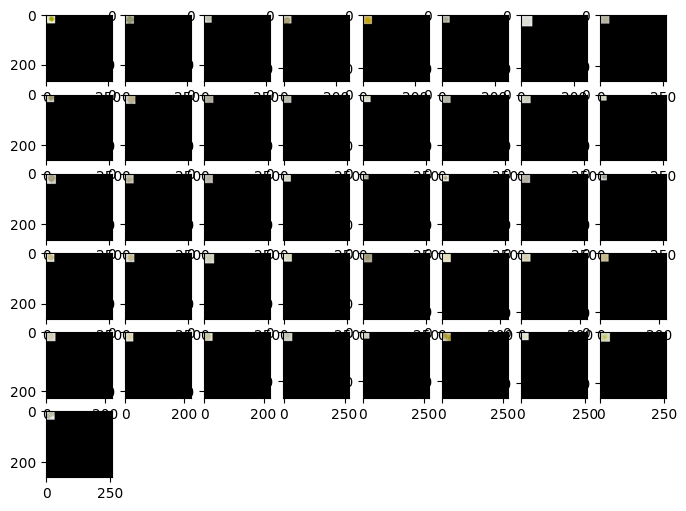

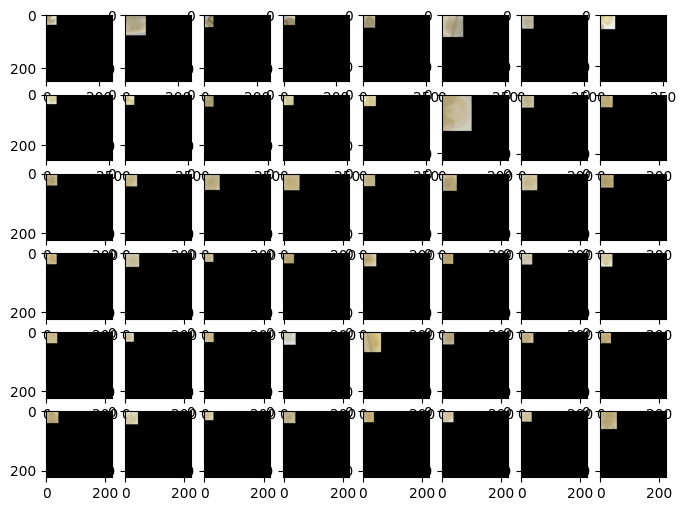

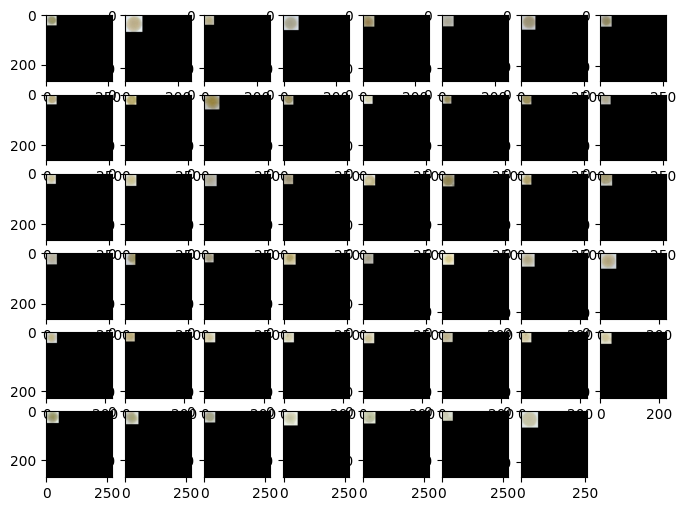

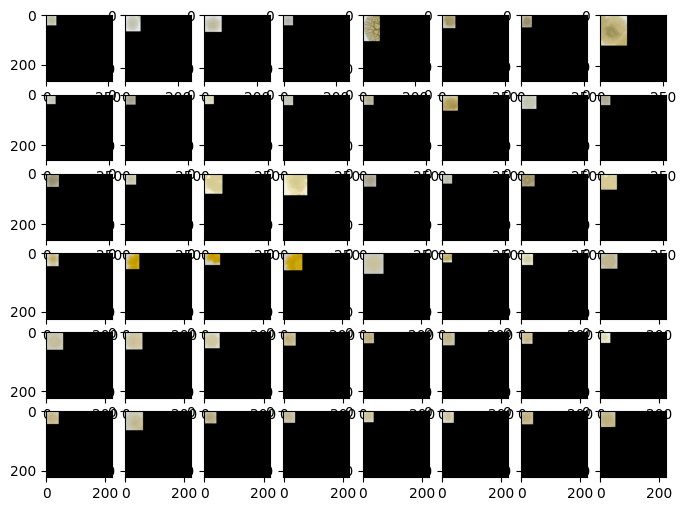

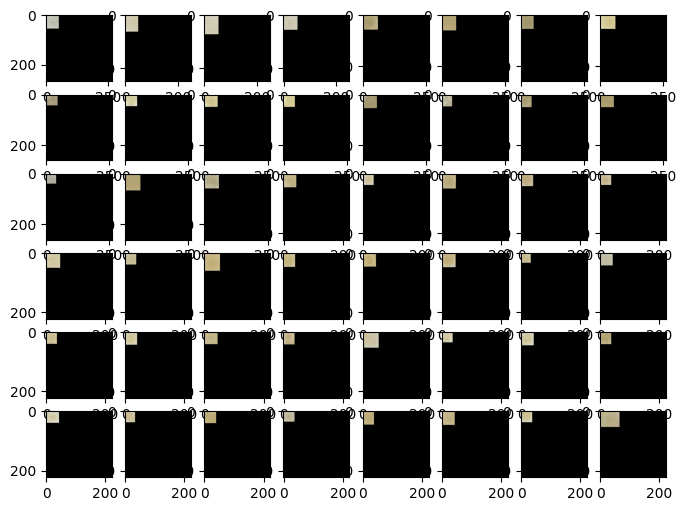

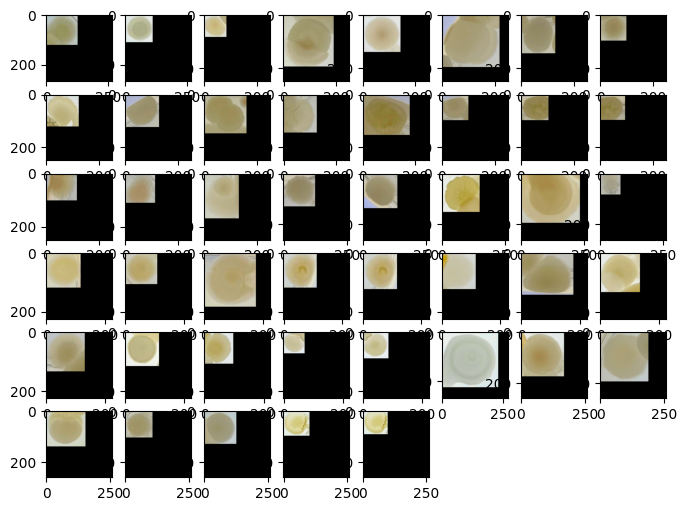

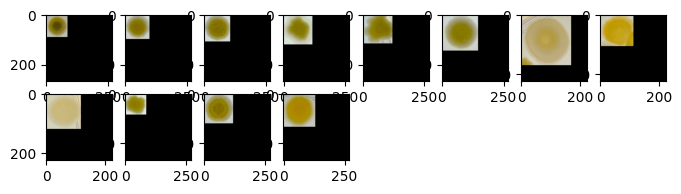

In [57]:
rows = 6
cols = 8
for image_cluster in image_clusters.values():
    nimgs = len(image_cluster) if len(image_cluster) < rows * cols + 1 else rows * cols
    plt.figure(figsize=(cols, rows))
    for c in range(nimgs):
        plt.subplot(rows, cols, c+1)
        plt.imshow(image_cluster[c])
    plt.show()

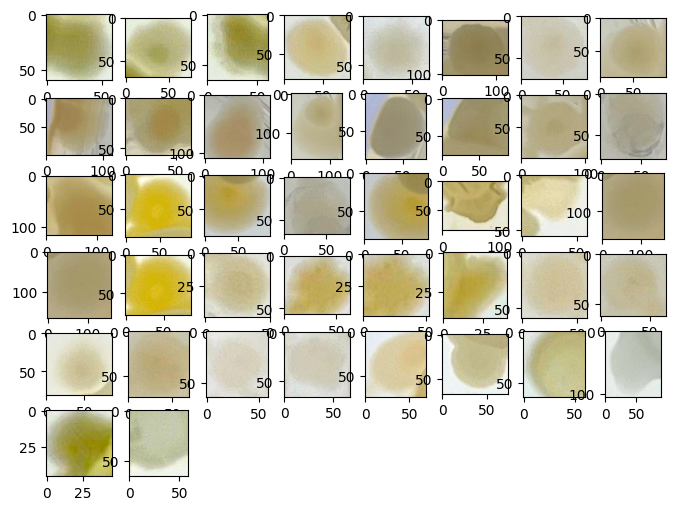

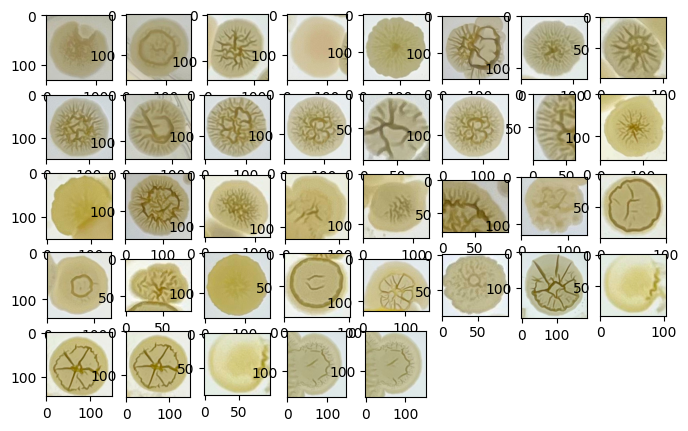

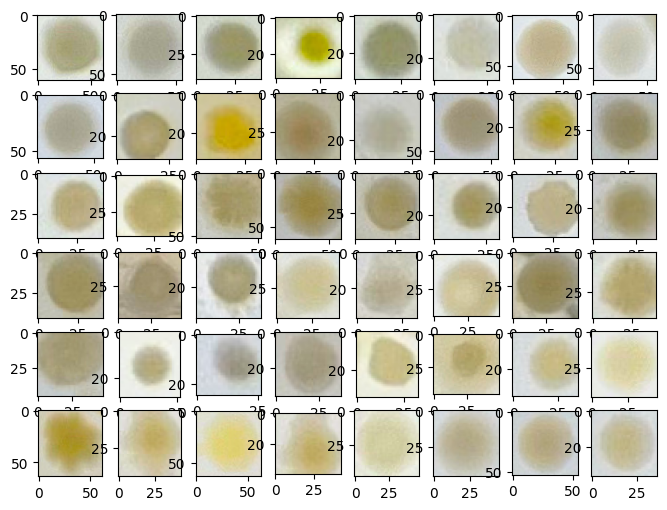

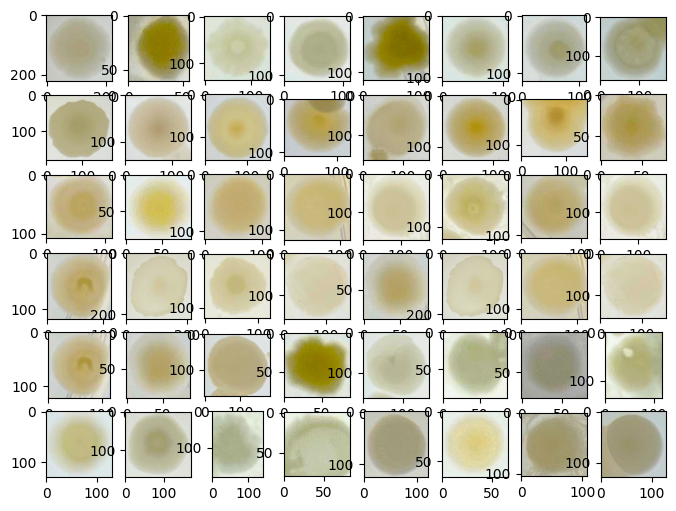

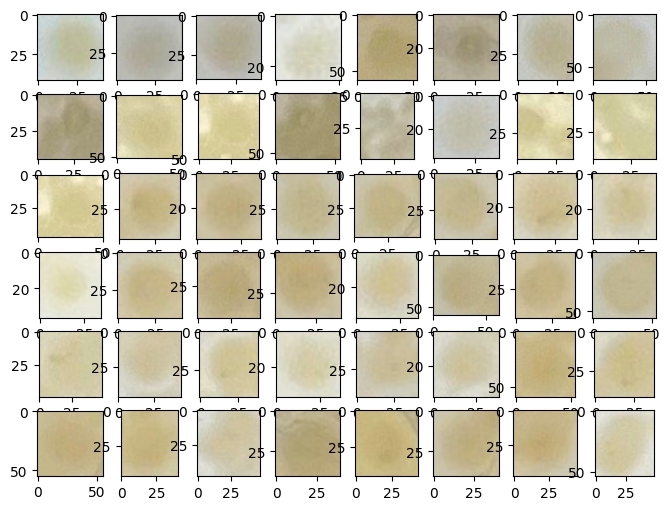

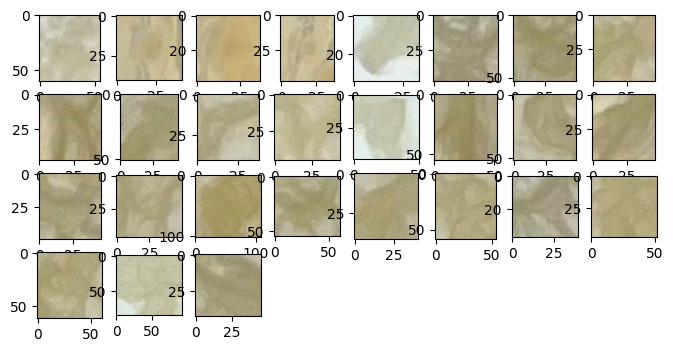

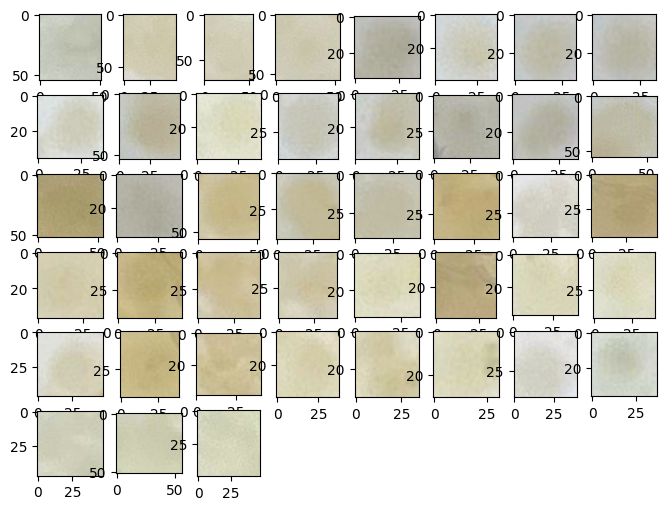

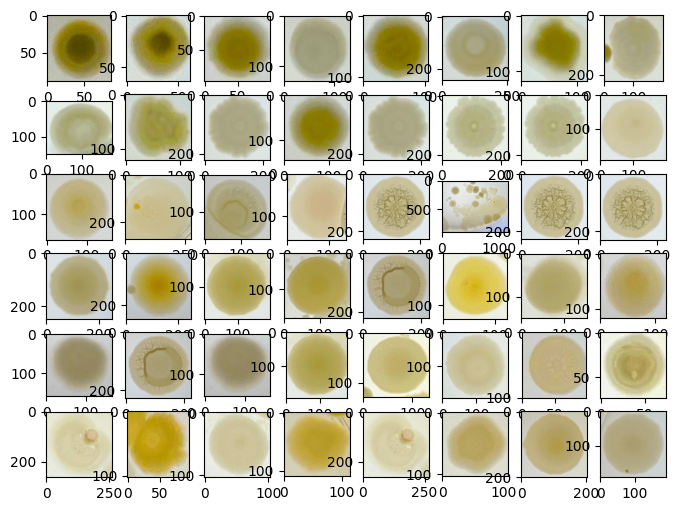

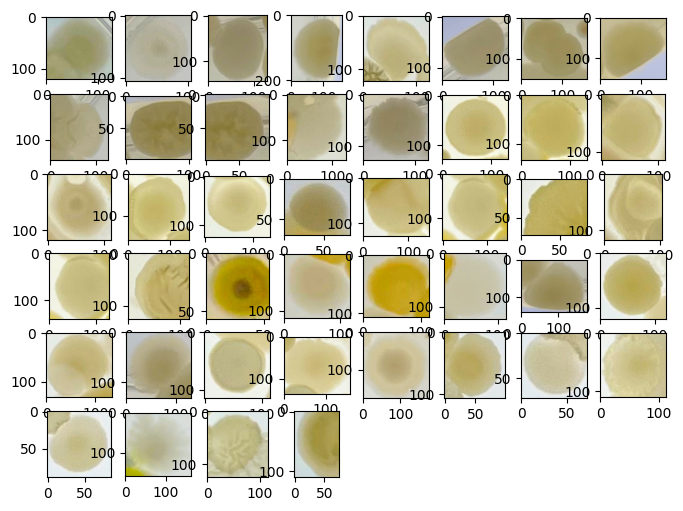

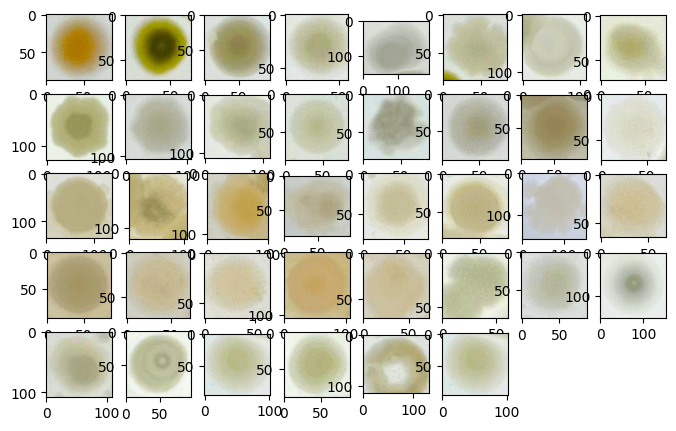

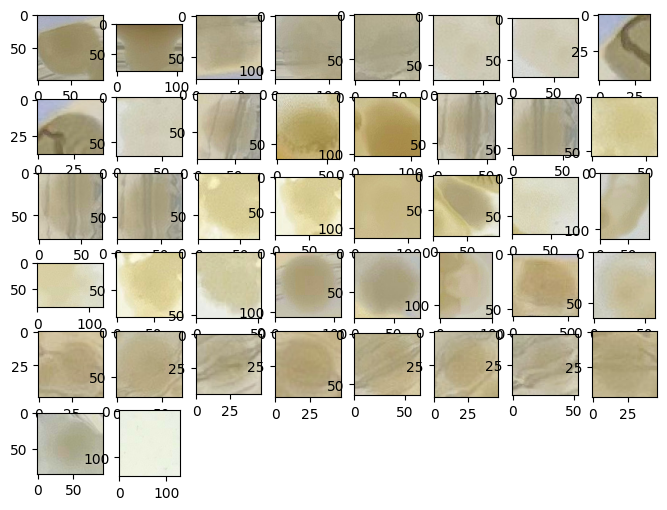

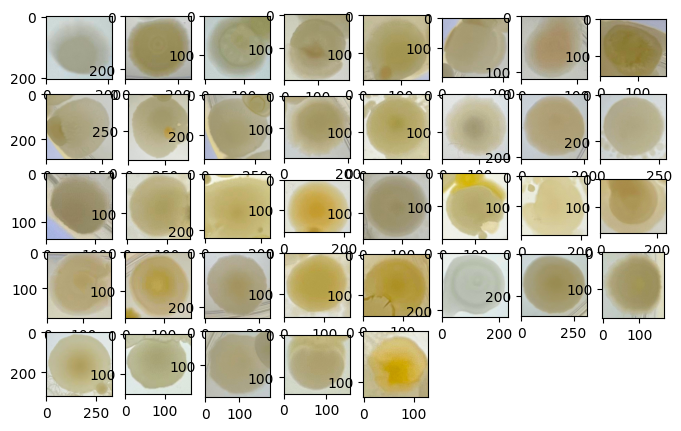

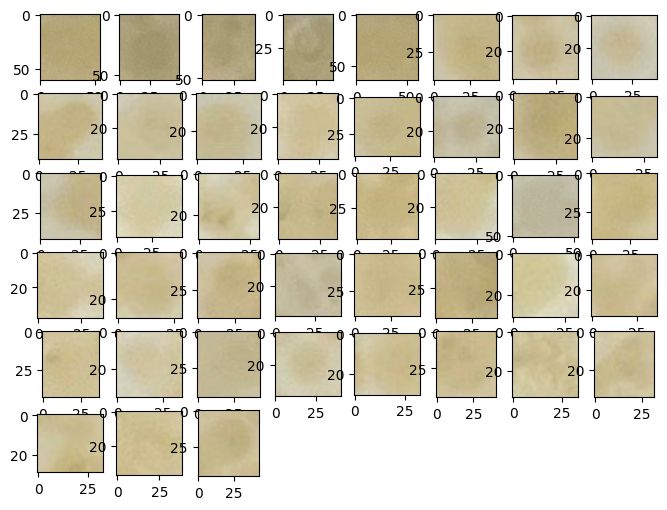

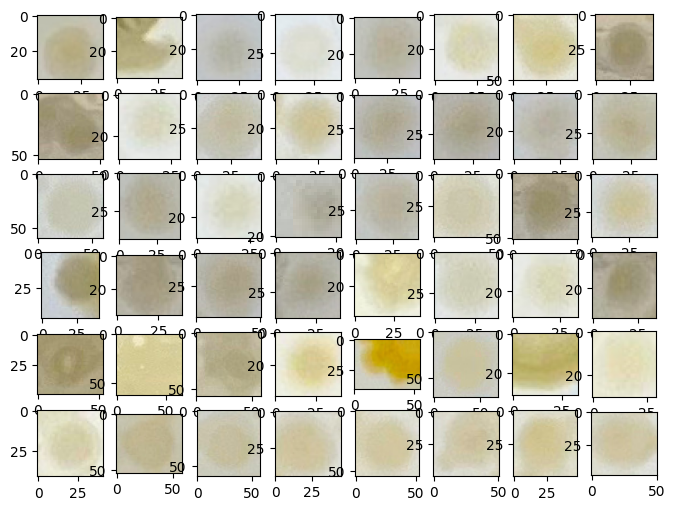

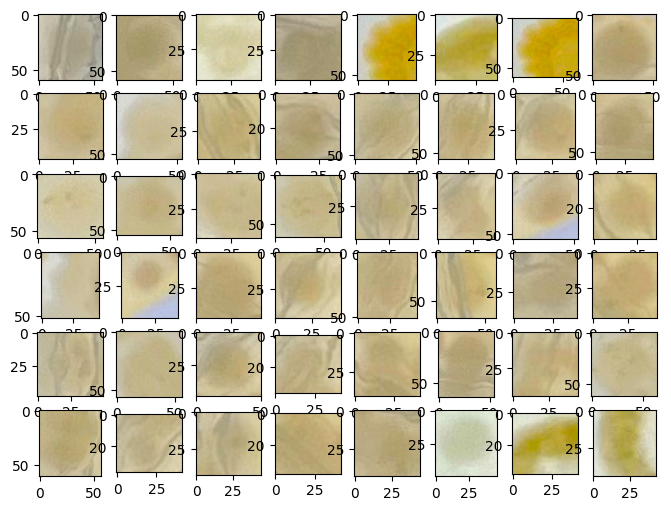

In [51]:
rows = 6
cols = 8
for image_cluster in image_clusters.values():
    nimgs = len(image_cluster) if len(image_cluster) < rows * cols + 1 else rows * cols
    plt.figure(figsize=(cols, rows))
    for c in range(nimgs):
        plt.subplot(rows, cols, c+1)
        plt.imshow(image_cluster[c])
    plt.show()


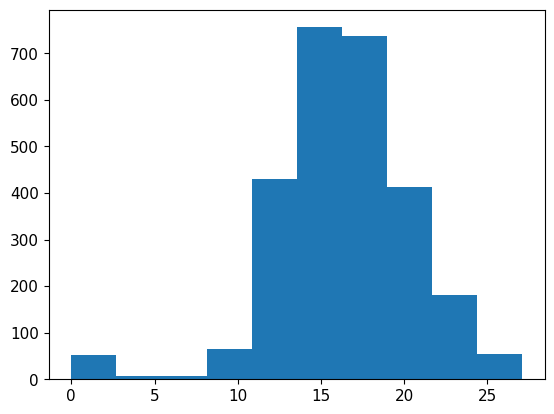

In [120]:
plt.hist(np.array(distance_map).flatten())
plt.show()